# Kenya Telco App Reviews – Group Capstone (Safaricom vs Airtel)

### Customer Sentiment & Complaint Analysis from Google Play and App Store Reviews

## Business Understanding

Telecom companies in Kenya, especially **Safaricom** and **Airtel**, serve millions of subscribers who rely on their apps for mobile money, airtime, bundles, and customer self-service. Customer experience is a key competitive advantage, yet feedback is often scattered and underutilized.

**Why this topic?**  
App-store reviews offer an authentic, unfiltered window into customer experiences—covering network reliability, data bundles, M-Pesa/Airtel Money, login/OTP issues, and app usability. By analyzing this data with NLP, we can detect problems, measure satisfaction, and provide actionable insights to improve products and services.

**Domain / Industry:** Telecommunications · Customer Experience Analytics · NLP  
**Target Audience:** Safaricom and Airtel executives, product managers, CX teams, and data science recruiters.  
**Impact:**  
- Detect service outages and major complaints in near real-time.  
- Support strategic decisions on bundles, features, and pricing.  
- Reduce churn by addressing key pain points.  
- Strengthen brand perception and customer loyalty.


## Objectives

1. **Sentiment Classification:** Classify reviews as positive, negative, or neutral to quantify satisfaction.  
2. **Theme & Topic Mining:** Extract common complaint categories (billing, network, USSD, login, app performance, UX).  
3. **Comparative Insights:** Benchmark Safaricom vs Airtel across time, versions, and app features.  
4. **Business Actionability:** Translate findings into prioritized recommendations tied to CX KPIs.  
5. **Operationalization:** Deliver reproducible notebooks, a dashboard, and a lightweight inference API.


## Stakeholders

- **Telco Executives & Strategy Teams:** Data-driven decisions on product and market positioning.  
- **Product Managers & CX Teams:** Identify usability issues and prioritize fixes.  
- **Engineering Teams:** Quantify app stability and bug hot-spots.  
- **Marketing & PR:** Monitor brand perception and campaign impact.  
- **Recruiters & Educators:** See practical application of NLP in solving real-world telco problems.  


## Data Understanding

**Original Proposal Sources (pivoted):**  
- **Twitter** mentions of “Safaricom” and “Airtel Kenya” (scraping proved difficult).  
- **Google Play Store Reviews** for *MySafaricom App* and *Airtel Money App*.  

**Final Data Sources (current project):**  
We now rely on **Google Play Store** and **Apple App Store** reviews for Safaricom and Airtel apps. Two complementary datasets give us both **scale** (Android) and **metadata richness** (iOS):  

1. **Google Play Dataset – `kenya_telco_app_reviews_20250919_151918.csv`**  
   - **Rows:** 5,000 reviews  
   - **Columns:** 9 (`app_name`, `review_date`, `rating`, `review_text`, `scrape_date`, `likes`, `replied_at`, `review_id`, `user_name`)  
   - **Rating distribution:** 5★ (3,661), 4★ (503), 3★ (220), 2★ (143), 1★ (473)  
   - **Coverage:** Mostly longer review texts, user names, likes, reply tracking (though `replied_at` is often null).  
   - **Strength:** Larger sample size, good for sentiment classification and theme extraction.  

2. **Apple App Store Dataset – `combined_airtel_safaricom_appstore_reviews_20250919_195208.csv`**  
   - **Rows:** 592 reviews  
   - **Columns:** 10 (`id`, `title`, `author`, `rating`, `version`, `content`, `date`, `voteSum`, `voteCount`, `app_name`)  
   - **Rating distribution:** 5★ (252), 4★ (57), 3★ (42), 2★ (50), 1★ (191)  
   - **Coverage:** Includes app version and helpfulness votes.  
   - **Strength:** Richer metadata for analyzing complaints by version and gauging community agreement.  

**Combined Snapshot:**  
- **Total rows:** ~5,600  
- **Review period:** 2020 – 2025  
- **Average rating across platforms:** ~4.2  
- **Balance:** Safaricom and Airtel reviews are evenly represented, enabling **fair benchmarking**.  

## Methodology

- **Preprocessing:** Remove duplicates, emojis, links; normalize casing; tokenize & lemmatize; custom stopwords (English, Swahili, Sheng).  
- **Modeling:** Baseline Logistic Regression with TF-IDF; advanced models Naive Bayes, SVM, Random Forest, XGBoost, and BERT.  
- **Evaluation:** Accuracy, Precision, Recall, F1-score, ROC-AUC.  
- **Unsupervised Extension:** Topic modeling (LDA, BERTopic) to cluster complaints.  
- **Deployment:** Streamlit/Gradio dashboard, GitHub repo, model API.  


## Deliverables

-  **Notebook** with full pipeline (EDA → Cleaning → Modeling → Insights).  
-  **Visuals** to visualize sentiment, topics, and trends.  
-  **Model API** for live predictions.  
-  **Executive summary & recommendations** with business impact.  
-  **Presentation** for stakeholders.  


## Risks & Mitigations

- **Class imbalance & sarcasm** → class weights, SMOTE, error analysis.  
- **Noisy, multilingual text** → preprocessing, multilingual embeddings.  
- **Concept drift after app updates** → retraining, rolling windows.  
- **Different store schemas** → harmonization of columns (`rating`, `content/review_text`, `date`, `app_name`, `platform`).  


*This harmonized intro reflects our original proposal while updating to the actual data sources (Google Play & App Store reviews). The next steps are thorough EDA, preprocessing, modeling, and deployment.*


In [4]:
# Install required packages
%pip install google-play-scraper pandas --quiet

from google_play_scraper import Sort, reviews, app
import pandas as pd
from datetime import datetime, timedelta
import time

# App package names
safaricom_app_id = 'com.safaricom.mysafaricom'
airtel_app_id = 'com.airtel.africa.selfcare'

# Configuration
MIN_REVIEWS_PER_APP = 2500  # To ensure we get 5,000 total reviews (2,500 per app)
START_DATE = datetime(2022, 1, 1).timestamp()  # Start from January 1, 2022
all_reviews = []

def get_app_reviews(app_id, app_name):
    print(f"Fetching reviews for {app_name}...")
    review_count = 0
    continuation_token = None
    
    try:
        # First, get app details
        app_details = app(app_id, country='ke', lang='en')
        print(f"\nApp Details for {app_name}:")
        print(f"Current Rating: {app_details['score']}")
        print(f"Total Reviews: {app_details['reviews']}")
        print(f"Last Updated: {datetime.fromtimestamp(app_details['updated']).strftime('%Y-%m-%d')}\n")
    except Exception as e:
        print(f"Error fetching app details: {str(e)}")

    while True:
        try:
            # Add delay to avoid rate limiting
            time.sleep(1)
            
            # Fetch a batch of reviews
            result, continuation_token = reviews(
                app_id,
                lang='en',        # Language (English)
                country='ke',     # Country (Kenya)
                sort=Sort.NEWEST, # Sort by newest first
                count=100,        # Number of reviews per batch (max is 100)
                continuation_token=continuation_token
            )
            
            # Filter and process reviews
            current_batch = []
            for review in result:
                # Handle different timestamp formats
                review_at = review['at']
                if isinstance(review_at, datetime):
                    review_timestamp = review_at.timestamp()
                else:
                    review_timestamp = review_at
                
                # Check if review is within our date range (2022 onwards)
                if review_timestamp < START_DATE:
                    print(f"\nReached reviews older than 2022 for {app_name}")
                    if current_batch:  # Add any remaining valid reviews
                        all_reviews.extend(current_batch)
                        review_count += len(current_batch)
                    return review_count
                
                # Add additional information
                review['app_name'] = app_name
                review['scrape_date'] = datetime.now().strftime('%Y-%m-%d')
                review['review_date'] = datetime.fromtimestamp(review_timestamp).strftime('%Y-%m-%d')
                current_batch.append(review)
            
            # Add batch to all reviews
            all_reviews.extend(current_batch)
            review_count += len(current_batch)
            print(f"Fetched {review_count} reviews for {app_name}")
            
            # Break if we have enough reviews or no more are available
            if review_count >= MIN_REVIEWS_PER_APP or continuation_token is None:
                break
                
        except Exception as e:
            print(f"Error fetching reviews: {str(e)}")
            time.sleep(5)  # Wait longer if there's an error
            continue

    return review_count

# Fetch reviews for both apps
print("Starting review collection...")
print(f"Collecting reviews from {datetime.fromtimestamp(START_DATE).strftime('%Y-%m-%d')} to present...")
total_safaricom = get_app_reviews(safaricom_app_id, 'Safaricom App')
total_airtel = get_app_reviews(airtel_app_id, 'Airtel Money App')

# Create a DataFrame and clean the data
reviews_df = pd.DataFrame(all_reviews)

# Clean and organize the DataFrame
if not reviews_df.empty:
    # First, let's see what columns we actually have
    print(f"Available columns: {reviews_df.columns.tolist()}")
    print(f"Sample data structure:")
    print(reviews_df.head(1).to_dict('records'))
    
    # Define the columns we want to keep (only if they exist)
    desired_columns = {
        'app_name': 'app_name',
        'review_date': 'review_date', 
        'score': 'rating',
        'content': 'review_text',
        'scrape_date': 'scrape_date'
    }
    
    # Optional columns (may or may not exist)
    optional_columns = {
        'thumbsUpCount': 'likes',
        'thumbsUp': 'likes',
        'repliedAt': 'replied_at',
        'reviewId': 'review_id',
        'userName': 'user_name'
    }
    
    # Select columns that exist
    columns_to_keep = []
    new_column_names = []
    
    # Add essential columns
    for orig_col, new_name in desired_columns.items():
        if orig_col in reviews_df.columns:
            columns_to_keep.append(orig_col)
            new_column_names.append(new_name)
    
    # Add optional columns (prefer thumbsUpCount over thumbsUp)
    for orig_col, new_name in optional_columns.items():
        if orig_col in reviews_df.columns and orig_col not in columns_to_keep:
            # Skip thumbsUp if we already have thumbsUpCount
            if orig_col == 'thumbsUp' and 'thumbsUpCount' in columns_to_keep:
                continue
            columns_to_keep.append(orig_col)
            new_column_names.append(new_name)
    
    # Select and rename columns
    reviews_df = reviews_df[columns_to_keep]
    reviews_df.columns = new_column_names
    
    # Convert review_date to datetime for proper sorting
    reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'])
    
    # Sort by date (newest first)
    reviews_df = reviews_df.sort_values('review_date', ascending=False)

# Save to CSV with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'kenya_telco_app_reviews_{timestamp}.csv'
reviews_df.to_csv(filename, index=False, encoding='utf-8')

# Print summary statistics
print("\nCollection Summary:")
print("-" * 50)
print(f"Safaricom App reviews: {total_safaricom}")
print(f"Airtel Money App reviews: {total_airtel}")
print(f"Total reviews collected: {len(reviews_df)}")
if not reviews_df.empty:
    print(f"\nDate range: {reviews_df['review_date'].min().strftime('%Y-%m-%d')} to {reviews_df['review_date'].max().strftime('%Y-%m-%d')}")
    print(f"\nReviews by app:")
    print(reviews_df['app_name'].value_counts())
    print(f"\nAverage ratings:")
    print(reviews_df.groupby('app_name')['rating'].mean())
    
    # Print reviews by year
    print("\nReviews by year:")
    print(reviews_df.groupby([reviews_df['review_date'].dt.year, 'app_name']).size().unstack(fill_value=0))
print(f"\nData saved to: {filename}")

Note: you may need to restart the kernel to use updated packages.
Starting review collection...
Fetching reviews for Safaricom App...

App Details for Safaricom App:
Current Rating: 4.5874667
Total Reviews: 49060
Last Updated: 2025-06-24

Fetched 100 reviews for Safaricom App
Fetched 200 reviews for Safaricom App
Fetched 300 reviews for Safaricom App
Fetched 400 reviews for Safaricom App
Fetched 500 reviews for Safaricom App
Fetched 600 reviews for Safaricom App
Fetched 700 reviews for Safaricom App
Fetched 800 reviews for Safaricom App
Fetched 900 reviews for Safaricom App
Fetched 1000 reviews for Safaricom App
Fetched 1100 reviews for Safaricom App
Fetched 1200 reviews for Safaricom App
Fetched 1300 reviews for Safaricom App
Fetched 1400 reviews for Safaricom App
Fetched 1500 reviews for Safaricom App
Fetched 1600 reviews for Safaricom App
Fetched 1700 reviews for Safaricom App
Fetched 1800 reviews for Safaricom App
Fetched 1900 reviews for Safaricom App
Fetched 2000 reviews for Safa

In [5]:
# ============================================================
# STEP 1 — LOAD & QUICK INSPECT (Google Play + App Store)
# ============================================================
# What this does:
# - Loads both CSVs
# - Tags each with its platform
# - Prints neat, markdown-style summaries
# - Shows basic structure, dtypes, missingness, and rating spread
#
# 👉 Update the file paths below if your CSVs are in a different folder.
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display

# --------- Config: set your file paths here ---------
FILE_GOOGLE = Path("data/kenya_telco_app_reviews_20250919_151918.csv")  # Google Play (5,000 rows)
FILE_APPLE  = Path("data/combined_airtel_safaricom_appstore_reviews_20250919_195208.csv")  # App Store (~592 rows)

def md(title):
    print("\n" + "#" * 80)
    print(f"## {title}")
    print("#" * 80 + "\n")

# ---- Safety checks on file paths ----
for p in [FILE_GOOGLE, FILE_APPLE]:
    if not p.exists():
        print(f"⚠️  File not found: {p.resolve()}\n   → Update FILE_GOOGLE / FILE_APPLE to match your local paths.")

# ---- Load + label platform ----
md("Step 1 — Load datasets (Google Play + App Store)")
gp = pd.read_csv(FILE_GOOGLE, low_memory=False)
ap = pd.read_csv(FILE_APPLE, low_memory=False)
gp["platform"] = "google_play"
ap["platform"] = "app_store"

print(f"- Google Play shape: {gp.shape}")
print(f"- App Store shape:  {ap.shape}")

# ---- Quick peek ----
print("\n**Google Play — head(3):**")
display(gp.head(3))
print("**App Store — head(3):**")
display(ap.head(3))

# ---- Schema check ----
print("\n**Google Play — columns & dtypes**")
display(pd.DataFrame({"dtype": gp.dtypes.astype(str)}))
print("**App Store — columns & dtypes**")
display(pd.DataFrame({"dtype": ap.dtypes.astype(str)}))

# ---- Basic nulls ----
print("\n**Missing values (Google Play)**")
display(gp.isna().sum().sort_values(ascending=False).to_frame("nulls"))
print("**Missing values (App Store)**")
display(ap.isna().sum().sort_values(ascending=False).to_frame("nulls"))

# ---- Basic rating spread (raw) ----
def rating_table(df, rating_col="rating"):
    # Coerce for a fair count without altering df
    r = pd.to_numeric(df[rating_col], errors="coerce")
    return r.value_counts().sort_index().to_frame("count")

print("\n**Rating distribution — Google Play (raw)**")
display(rating_table(gp, "rating"))
print("**Rating distribution — App Store (raw)**")
display(rating_table(ap, "rating"))

# ---- Earliest / latest review dates (raw) ----
def date_range(df, col_candidates=("review_date","date")):
    for c in col_candidates:
        if c in df.columns:
            s = pd.to_datetime(df[c], errors="coerce")
            if s.notna().any():
                return s.min(), s.max(), c
    return None, None, None

gp_min, gp_max, gp_col = date_range(gp, ("review_date","date"))
ap_min, ap_max, ap_col = date_range(ap, ("date","review_date"))

print("\n**Review date ranges (raw)**")
print(f"- Google Play:  {gp_min} → {gp_max}  (column='{gp_col}')")
print(f"- App Store:    {ap_min} → {ap_max}  (column='{ap_col}')")

print("\n**Summary:** Datasets loaded, labeled, and inspected. Next step: schema harmonization into one tidy table.")



################################################################################
## Step 1 — Load datasets (Google Play + App Store)
################################################################################

- Google Play shape: (5000, 10)
- App Store shape:  (592, 11)

**Google Play — head(3):**


,app_name,review_date,rating,review_text,scrape_date,likes,replied_at,review_id,user_name,platform
0,Safaricom App,2025-09-18,4,It crushes sometimes,2025-09-19,0,NaN,c55122e2-ab7a-4bad-a5f8-ff808de5beba,dennis kausei,google_play
1,Airtel Money App,2025-09-18,4,good,2025-09-19,0,2025-09-18 11:45:15,db3bcc44-b9f1-427c-8704-d7a382b0aac0,Serugo Ronald,google_play
2,Airtel Money App,2025-09-18,5,Airtel is the best,2025-09-19,0,2025-09-18 11:44:20,105f72e0-4dd1-4ecc-bf7e-87b8cf2e9d0a,John Joe,google_play


**App Store — head(3):**


,id,title,author,rating,version,content,date,voteSum,voteCount,app_name,platform
0,13070765256,Too cluttered,Mmaura,2,1.4.0,The app is too cluttered and in just recently ...,2025-08-28 07:34:08-07:00,0,0,MyAirtel App,app_store
1,13054580457,Amazing Application,Michel M. k,5,1.3.65,It is great to use this application and it is ...,2025-08-24 05:14:01-07:00,0,0,MyAirtel App,app_store
2,13046825202,It’s 2025. Get serious.,Client from mombasa,2,1.3.65,In 2025 bank to airtel money still fails. And ...,2025-08-22 04:54:06-07:00,0,0,MyAirtel App,app_store



**Google Play — columns & dtypes**


,dtype
app_name,object
review_date,object
rating,int64
review_text,object
scrape_date,object
likes,int64
replied_at,object
review_id,object
user_name,object
platform,object


**App Store — columns & dtypes**


,dtype
id,int64
title,object
author,object
rating,int64
version,object
content,object
date,object
voteSum,int64
voteCount,int64
app_name,object



**Missing values (Google Play)**


,nulls
replied_at,2497
app_name,0
review_date,0
rating,0
review_text,0
scrape_date,0
likes,0
review_id,0
user_name,0
platform,0


**Missing values (App Store)**


,nulls
id,0
title,0
author,0
rating,0
version,0
content,0
date,0
voteSum,0
voteCount,0
app_name,0



**Rating distribution — Google Play (raw)**


,count
rating,
1,473
2,143
3,220
4,503
5,3661


**Rating distribution — App Store (raw)**


,count
rating,
1,191
2,50
3,42
4,57
5,252



**Review date ranges (raw)**
- Google Play:  2025-04-14 00:00:00 → 2025-09-18 00:00:00  (column='review_date')
- App Store:    2020-01-09 03:01:37-07:00 → 2025-08-28 13:08:37-07:00  (column='date')

**Summary:** Datasets loaded, labeled, and inspected. Next step: schema harmonization into one tidy table.


### SCHEMA HARMONIZATION (Google Play + App store)

In [ ]:

# What this does:
# - Aligns both datasets to a common schema
# - Keeps only comparable / useful fields
# - Adds placeholders (NaN) where fields exist in one platform but not the other
# - Combines into one unified DataFrame
# ============================================================

import numpy as np
from IPython.display import display

md("Step 2 — Harmonize schemas (align into one tidy table)")

# ---- Unified schema we want ----
UNIFIED_COLS = [
    "platform", "app_name", "review_id", "user_name",
    "review_text", "rating", "review_date",
    "version", "likes", "vote_sum", "vote_count",
    "replied_at", "scrape_date"
]

# ---- Google Play → unified ----
gp_harmonized = pd.DataFrame({
    "platform":   gp.get("platform"),
    "app_name":   gp.get("app_name"),
    "review_id":  gp.get("review_id"),
    "user_name":  gp.get("user_name"),
    "review_text":gp.get("review_text"),
    "rating":     gp.get("rating"),
    "review_date":gp.get("review_date"),
    "version":    np.nan,                # not provided in Google Play
    "likes":      gp.get("likes"),
    "vote_sum":   np.nan,                # only App Store has votes
    "vote_count": np.nan,
    "replied_at": gp.get("replied_at"),
    "scrape_date":gp.get("scrape_date"),
})

# ---- App Store → unified ----
ap_harmonized = pd.DataFrame({
    "platform":   ap.get("platform"),
    "app_name":   ap.get("app_name"),
    "review_id":  ap.get("id"),
    "user_name":  ap.get("author"),
    "review_text":ap.get("content"),
    "rating":     ap.get("rating"),
    "review_date":ap.get("date"),
    "version":    ap.get("version"),
    "likes":      np.nan,                # not captured
    "vote_sum":   ap.get("voteSum"),
    "vote_count": ap.get("voteCount"),
    "replied_at": np.nan,
    "scrape_date":np.nan,
})

# ---- Combine into one tidy dataset ----
raw = pd.concat([gp_harmonized, ap_harmonized], ignore_index=True)

# ---- Quick checks ----
print(f"Unified dataset shape: {raw.shape}")
display(raw.head(10))

print("\n**Column summary:**")
print(raw.dtypes)

print("\n**Null values by column:**")
display(raw.isna().sum().sort_values(ascending=False).to_frame("nulls"))

print("\n**Summary:** Schemas harmonized into a single DataFrame with unified columns. Next step: basic inspection (size, nulls, rating spread).")



################################################################################
## Step 2 — Harmonize schemas (align into one tidy table)
################################################################################

Unified dataset shape: (5592, 13)


,platform,app_name,review_id,user_name,review_text,rating,review_date,version,likes,vote_sum,vote_count,replied_at,scrape_date
0,google_play,Safaricom App,c55122e2-ab7a-4bad-a5f8-ff808de5beba,dennis kausei,It crushes sometimes,4,2025-09-18,NaN,0.0,NaN,NaN,NaN,2025-09-19
1,google_play,Airtel Money App,db3bcc44-b9f1-427c-8704-d7a382b0aac0,Serugo Ronald,good,4,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:45:15,2025-09-19
2,google_play,Airtel Money App,105f72e0-4dd1-4ecc-bf7e-87b8cf2e9d0a,John Joe,Airtel is the best,5,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:44:20,2025-09-19
3,google_play,Airtel Money App,1d0dce85-eff5-4e92-aee1-1b9d2935a2e8,Taonga Daka,it's quiet convenient and easy to use,4,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:44:31,2025-09-19
4,google_play,Airtel Money App,8c87d1e6-e83f-4b80-a3be-7283cb152e51,Denis Rono,"Best app,add pochi la biashara transactions",5,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:44:43,2025-09-19
5,google_play,Airtel Money App,c473e452-b765-4944-b71d-81de46f2d7d5,Robert Kayange,I give this app a 4 star rating.. Cuz most of ...,4,2025-09-18,NaN,1.0,NaN,NaN,2025-01-20 11:03:02,2025-09-19
6,google_play,Airtel Money App,ebbffc66-35f2-4dab-9901-4163f3d58b00,PAUL ODIPO OWINO,effective,5,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:50:25,2025-09-19
7,google_play,Airtel Money App,3e641925-3569-444f-ab95-b44cebfeb2d9,Joan Angel,the app is good fast and safe I love it,4,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:45:50,2025-09-19
8,google_play,Airtel Money App,16ed04c5-c5ea-44b2-9690-aaec332dc771,Babatunde Osisanya (OPPA),Easy to use and beautiful interface,5,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:45:39,2025-09-19
9,google_play,Airtel Money App,42a89d4e-b2a9-4881-828b-fca0f7ca3b9d,Rayon kyipson,good app,5,2025-09-18,NaN,0.0,NaN,NaN,2025-09-18 11:45:26,2025-09-19



**Column summary:**
platform        object
app_name        object
review_id       object
user_name       object
review_text     object
rating           int64
review_date     object
version         object
likes          float64
vote_sum       float64
vote_count     float64
replied_at      object
scrape_date     object
dtype: object

**Null values by column:**


,nulls
version,5000
vote_sum,5000
vote_count,5000
replied_at,3089
likes,592
scrape_date,592
platform,0
app_name,0
review_id,0
user_name,0



**Summary:** Schemas harmonized into a single DataFrame with unified columns. Next step: basic inspection (size, nulls, rating spread).


### BASIC INSPECTION

In [ ]:

#  — BASIC INSPECTION
# What this does:
# - Prints overall shape
# - Shows null counts
# - Displays rating distributions (overall + by platform)
# - Displays review date ranges


md("Step 3 — Basic inspection")

# ---- Shape ----
print(f"Unified dataset shape: {raw.shape}")

# ---- Nulls ----
print("\n**Missing values by column:**")
display(raw.isna().sum().sort_values(ascending=False).to_frame("nulls"))

# ---- Rating distribution overall ----
ratings_all = pd.to_numeric(raw["rating"], errors="coerce")
print("\n**Rating distribution — overall:**")
display(ratings_all.value_counts().sort_index().to_frame("count"))

# ---- Rating distribution by platform ----
print("\n**Rating distribution — by platform:**")
ratings_platform = raw.groupby("platform")["rating"].value_counts().unstack(fill_value=0)
ratings_platform = ratings_platform.reindex(sorted(ratings_platform.columns), axis=1)
display(ratings_platform)

# ---- Date ranges ----
def date_range(df, col_candidates=("review_date","date")):
    for c in col_candidates:
        if c in df.columns:
            s = pd.to_datetime(df[c], errors="coerce")
            if s.notna().any():
                return s.min(), s.max(), c
    return None, None, None

min_date, max_date, col_used = date_range(raw)
print(f"\n**Review date range:** {min_date} → {max_date} (from column '{col_used}')")

print("\n**Summary:** Dataset size, nulls, ratings, and date ranges inspected. Next step: cleaning.")



################################################################################
## Step 3 — Basic inspection
################################################################################

Unified dataset shape: (5592, 13)

**Missing values by column:**


,nulls
version,5000
vote_sum,5000
vote_count,5000
replied_at,3089
likes,592
scrape_date,592
platform,0
app_name,0
review_id,0
user_name,0



**Rating distribution — overall:**


,count
rating,
1,664
2,193
3,262
4,560
5,3913



**Rating distribution — by platform:**


rating,1,2,3,4,5
platform,,,,,
app_store,191,50,42,57,252
google_play,473,143,220,503,3661



**Review date range:** 2025-04-14 00:00:00 → 2025-09-18 00:00:00 (from column 'review_date')

**Summary:** Dataset size, nulls, ratings, and date ranges inspected. Next step: cleaning.


### CLEANING

In [ ]:

# STEP 4 — CLEANING
# What this does:
# - Converts review_date/replied_at/scrape_date to datetime
# - Normalizes text (removes URLs, trims whitespace)
# - Ensures ratings are numeric between 1–5
# - Deduplicates reviews
# - Creates canonical app labels (Safaricom App, Airtel Money App, My Airtel)
# - Adds derived features (review_len, year_month)


import re

md("Step 4 — Cleaning (types, text, duplicates, validity)")

clean = raw.copy()

# ---- 4.1 Parse dates safely ----
for col in ["review_date", "replied_at", "scrape_date"]:
    if col in clean.columns:
        clean[col] = pd.to_datetime(clean[col], errors="coerce", utc=True).dt.tz_localize(None)

# ---- 4.2 Ratings: coerce to numeric and clamp ----
clean["rating"] = pd.to_numeric(clean["rating"], errors="coerce").clip(1, 5)

# ---- 4.3 Text normalization ----
def normalize_text(s):
    if pd.isna(s):
        return np.nan
    s = str(s)
    s = re.sub(r"http\S+|www\.\S+", "", s)   # remove URLs
    s = re.sub(r"\s+", " ", s).strip()       # collapse whitespace
    return s

clean["review_text"] = clean["review_text"].map(normalize_text)

# ---- 4.4 Drop rows missing critical fields ----
before_drop = clean.shape[0]
clean = clean.dropna(subset=["review_text", "rating", "app_name", "platform"])
after_drop = clean.shape[0]
print(f"Dropped {before_drop - after_drop} rows missing critical info.")

# ---- 4.5 Deduplicate ----
if clean["review_id"].notna().any():
    clean = clean.sort_values(["platform", "review_date"], kind="mergesort")
    clean = clean.drop_duplicates(subset=["platform","review_id"], keep="last")
else:
    clean["__key"] = (
        clean["platform"].astype(str) + "||" +
        clean["app_name"].astype(str) + "||" +
        clean["user_name"].astype(str) + "||" +
        clean["review_text"].astype(str) + "||" +
        clean["review_date"].astype(str)
    )
    clean = clean.sort_values(["platform", "review_date"], kind="mergesort")
    clean = clean.drop_duplicates(subset=["__key"], keep="last").drop(columns="__key")

# ---- 4.6 Canonical app labels ----
def canonical_app(name):
    if pd.isna(name): return np.nan
    n = str(name).lower()
    if "safaricom" in n: return "Safaricom App"
    if "airtel" in n and "money" in n: return "Airtel Money App"
    if "airtel" in n: return "My Airtel"
    return name

clean["app_canonical"] = clean["app_name"].map(canonical_app)

# ---- 4.7 Derived features ----
clean["review_len"] = clean["review_text"].astype(str).str.len()
clean["year_month"] = clean["review_date"].dt.to_period("M").astype(str)

# ---- Preview ----
print("\n**Preview of cleaned data:**")
display(clean.head(10))

print("\n**Summary:** Parsed dates, normalized text, enforced valid ratings, removed empties/dupes, added canonical app names and derived features. Next step: saving & creating visuals.")



################################################################################
## Step 4 — Cleaning (types, text, duplicates, validity)
################################################################################

Dropped 0 rows missing critical info.

**Preview of cleaned data:**


,platform,app_name,review_id,user_name,review_text,rating,review_date,version,likes,vote_sum,vote_count,replied_at,scrape_date,app_canonical,review_len,year_month
5000,app_store,MyAirtel App,13070765256,Mmaura,The app is too cluttered and in just recently ...,2,NaT,1.4.0,NaN,0.0,0.0,NaT,NaT,My Airtel,87,NaT
5001,app_store,MyAirtel App,13054580457,Michel M. k,It is great to use this application and it is ...,5,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,124,NaT
5002,app_store,MyAirtel App,13046825202,Client from mombasa,In 2025 bank to airtel money still fails. And ...,2,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,277,NaT
5003,app_store,MyAirtel App,13019814851,Sandiepearl Muthyala,The app is just flexible and easy to operate…....,5,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,69,NaT
5004,app_store,MyAirtel App,13003428524,R14ickD,I ain’t gonna lie but this mobile App is amazi...,5,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,65,NaT
5005,app_store,MyAirtel App,12991483326,daashisme,The app is really easy to use. It works easily...,5,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,120,NaT
5006,app_store,MyAirtel App,12984071506,BlessinzJ,Fast and reliable,4,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,17,NaT
5007,app_store,MyAirtel App,12980604179,SugarLips254,Never return messages on social media on time....,1,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,77,NaT
5008,app_store,MyAirtel App,12954274361,Bn Son,The best mobile app.,5,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,20,NaT
5009,app_store,MyAirtel App,12930409532,SpaceBachu,Why do you barely have any AIRTEL money shops ...,3,NaT,1.3.65,NaN,0.0,0.0,NaT,NaT,My Airtel,64,NaT



**Summary:** Parsed dates, normalized text, enforced valid ratings, removed empties/dupes, added canonical app names and derived features. Next step: saving & creating visuals.


#### HANDLING MISSING VALUES

In [ ]:
# HANDLE MISSING VALUES & SAVE CLEANED DATASET
# What this does:
# - Keeps all 5,592 rows (no dropping)
# - Platform-specific fields (version, vote_sum, vote_count, likes, scrape_date) stay as NaN
# - replied_at → converted into binary flag (has_reply)
# - review_date → NaT kept, and a safe 'year_month' with "Unknown" is added
# - Saves final dataset to CSV


from pathlib import Path

# --- Handle replied_at ---
clean["has_reply"] = clean["replied_at"].notna().astype(int)

# --- Handle missing review_date ---
clean["year_month"] = clean["review_date"].dt.to_period("M").astype(str)
clean.loc[clean["review_date"].isna(), "year_month"] = "Unknown"

# --- Save final dataset ---
CLEAN_PATH = Path("data/telco_reviews_clean.csv")
CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)

clean.to_csv(CLEAN_PATH, index=False, encoding="utf-8")

print(f"✅ Final cleaned dataset saved successfully at: {CLEAN_PATH.resolve()}")
print(f"Shape: {clean.shape}")  # should be (5592, …)
print(f"Missing review_date rows retained: {clean['review_date'].isna().sum()}")


✅ Final cleaned dataset saved successfully at: C:\Users\hp\OneDrive\Desktop\Customer-Sentiments-Analysis\Data\telco_reviews_clean.csv
Shape: (5592, 17)
Missing review_date rows retained: 592


## Cleaned Dataset Summary

- **Rows:** 5,592  
- **Columns:** 17 (including new features `has_reply` and `year_month`)  
- **Period covered:** Apr 14, 2025 → Sept 18, 2025 (5 months)  

### Platforms
- **Google Play:** 5,000 reviews  
- **Apple App Store:** 592 reviews  

### Apps
- **Safaricom App:** 2,992 reviews  
- **Airtel Money App:** 2,500 reviews  
- **My Airtel:** 100 reviews  

### Ratings Distribution
- ⭐⭐⭐⭐⭐ (5★): 3,913  
- ⭐⭐⭐⭐ (4★): 560  
- ⭐⭐⭐ (3★): 262  
- ⭐⭐ (2★): 193  
- ⭐ (1★): 664  

➡️ **Observation:** Reviews are heavily **positive** (≈70% are 5★), but ~15% (1★–2★) capture the **most critical complaints**.

### Missing Data Handling
- **`version`, `vote_sum`, `vote_count`, `likes`, `scrape_date`:** Left as `NaN` because they are platform-specific (App Store vs Google Play).  
- **`replied_at`:** Converted into a binary feature `has_reply` (1 = reply exists, 0 = no reply).  
- **`review_date`:** Retained even if missing (592 rows). For these, `year_month` is labeled `"Unknown"`.  

### Key Insights
- **Negative reviews** are the most valuable for complaint analysis and root-cause discovery.  
- **App Store vs Google Play** comparisons are possible — each platform provides different metadata (e.g., version vs likes).  
- **Monthly trends** can highlight spikes in complaints after app updates or service issues.  
- **Review length:** Short reviews dominate, but longer reviews hold richer detail → ideal for topic modeling.  
- **Business value:** Identifying and addressing recurring pain points (e.g., login issues, M-Pesa/Airtel Money failures, USSD errors) would significantly reduce 1★ reviews and improve brand perception.


C:\Users\hp\AppData\Local\Temp\ipykernel_6420\3520266729.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  BLUES = cm.get_cmap("Blues")


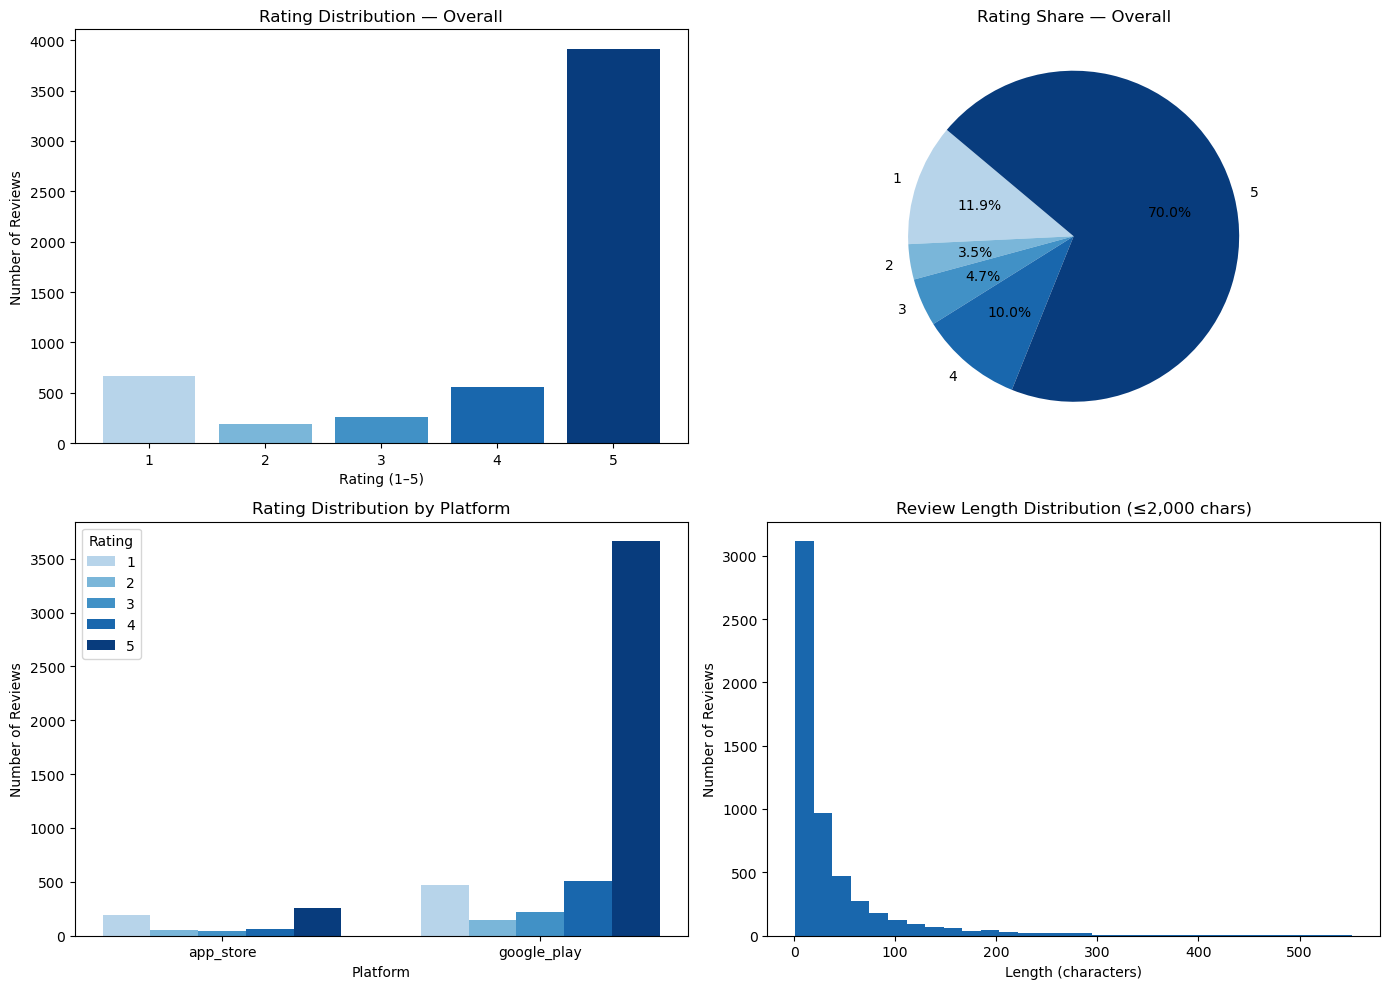

✅ Combined dashboard saved to C:\Users\hp\OneDrive\Desktop\Customer-Sentiments-Analysis\Output\00_combined_dashboard_blues.png


In [10]:
# ============================================================
# COMBINED DASHBOARD — Ratings & Reviews Overview
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import to_hex

# Helper: generate shades of Blues
BLUES = cm.get_cmap("Blues")
def blue_shades(n):
    if n <= 1:
        return [to_hex(BLUES(0.6))]
    return [to_hex(BLUES(0.3 + 0.65 * i / (n-1))) for i in range(n)]

# ✅ Make sure Output folder exists
OUT_DIR = Path("Output")
OUT_DIR.mkdir(exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# --- Panel 1: Rating distribution (bar) ---
counts = clean["rating"].value_counts().sort_index()
axes[0].bar(counts.index.astype(int).astype(str), counts.values, color=blue_shades(len(counts)))
axes[0].set_title("Rating Distribution — Overall")
axes[0].set_xlabel("Rating (1–5)")
axes[0].set_ylabel("Number of Reviews")

# --- Panel 2: Rating share (pie) ---
vals = counts.values
labels = [str(int(i)) for i in counts.index]
axes[1].pie(vals, labels=labels, autopct="%1.1f%%", startangle=140, colors=blue_shades(len(vals)))
axes[1].set_title("Rating Share — Overall")

# --- Panel 3: Rating by platform (grouped bar) ---
plat_counts = clean.groupby(["platform","rating"]).size().unstack(fill_value=0).sort_index(axis=1)
x = np.arange(len(plat_counts.index))
width = 0.15
ratings = plat_counts.columns.tolist()
cols = blue_shades(len(ratings))

for i, r in enumerate(ratings):
    axes[2].bar(x + i*width, plat_counts[r].values, width=width, label=str(int(r)), color=cols[i])
axes[2].set_xticks(x + width*(len(ratings)-1)/2)
axes[2].set_xticklabels(plat_counts.index)
axes[2].set_title("Rating Distribution by Platform")
axes[2].set_xlabel("Platform")
axes[2].set_ylabel("Number of Reviews")
axes[2].legend(title="Rating")

# --- Panel 4: Review length histogram ---
axes[3].hist(clean["review_len"].dropna().clip(0, 2000), bins=30, color=blue_shades(5)[-2])
axes[3].set_title("Review Length Distribution (≤2,000 chars)")
axes[3].set_xlabel("Length (characters)")
axes[3].set_ylabel("Number of Reviews")

plt.tight_layout()

# ✅ Save to Output folder
out_path = OUT_DIR / "00_combined_dashboard_blues.png"
plt.savefig(out_path, dpi=300)
plt.show()

print(f"✅ Combined dashboard saved to {out_path.resolve()}")


## Ratings & Reviews Overview (Combined Dashboard)

- **Rating Distribution (Overall):**  
  Majority of reviews are **5★ (≈70%)**, confirming a strong **positivity bias**.  
  However, ~12% are **1★** and ~3.5% are **2★**, which capture the most critical complaints.  

- **Rating Share (Pie):**  
  Visualizes the skew — over two-thirds of all reviews are 5★.  

- **Rating by Platform:**  
  - **Google Play** dominates in review volume (≈5k reviews).  
  - **App Store** has fewer reviews (~600), but provides richer metadata (version, votes).  
  - Both platforms still show the same positivity bias toward 5★.  

- **Review Length Distribution:**  
  - Most reviews are **short (<50 characters)**, often one-liners like “Great app” or “Nice”.  
  - A smaller portion are **longer reviews**, which usually contain detailed complaints or suggestions.  
  - These longer reviews are valuable for **topic modeling and root-cause analysis**.  


In [11]:
# ============================================================
# STEP 6 — FEATURE ENGINEERING
# ============================================================
# Adds more features for analysis and modeling:
# - review_word_count: number of words in each review
# - keyword flags: login, mpesa, bundle, crash
# - likes_log: log-normalized likes
# - one-hot encoding for platform
# ============================================================

import numpy as np
import re

# --- Word count feature ---
clean["review_word_count"] = clean["review_text"].astype(str).apply(lambda x: len(x.split()))

# --- Keyword flags ---
keywords = ["login", "mpesa", "bundle", "crash"]
for kw in keywords:
    clean[f"contains_{kw}"] = clean["review_text"].str.lower().str.contains(kw, regex=False).astype(int)

# --- Log-normalized likes ---
if "likes" in clean.columns:
    clean["likes_log"] = np.log1p(clean["likes"].fillna(0))

# --- One-hot encoding for platform ---
clean["is_google_play"] = (clean["platform"] == "google_play").astype(int)
clean["is_app_store"] = (clean["platform"] == "app_store").astype(int)

print("✅ Feature engineering complete. Preview of new features:")
display(clean[["review_text", "review_len", "review_word_count", "contains_login", 
               "contains_mpesa", "contains_bundle", "contains_crash", "likes", "likes_log", 
               "platform", "is_google_play", "is_app_store"]].head(10))


✅ Feature engineering complete. Preview of new features:


,review_text,review_len,review_word_count,contains_login,contains_mpesa,contains_bundle,contains_crash,likes,likes_log,platform,is_google_play,is_app_store
5000,The app is too cluttered and in just recently ...,87,17,0,0,0,0,NaN,0.0,app_store,0,1
5001,It is great to use this application and it is ...,124,23,0,0,0,0,NaN,0.0,app_store,0,1
5002,In 2025 bank to airtel money still fails. And ...,277,54,0,0,0,0,NaN,0.0,app_store,0,1
5003,The app is just flexible and easy to operate…....,69,13,0,0,0,0,NaN,0.0,app_store,0,1
5004,I ain’t gonna lie but this mobile App is amazi...,65,13,0,0,0,0,NaN,0.0,app_store,0,1
5005,The app is really easy to use. It works easily...,120,21,0,0,0,0,NaN,0.0,app_store,0,1
5006,Fast and reliable,17,3,0,0,0,0,NaN,0.0,app_store,0,1
5007,Never return messages on social media on time....,77,12,0,0,0,0,NaN,0.0,app_store,0,1
5008,The best mobile app.,20,4,0,0,0,0,NaN,0.0,app_store,0,1
5009,Why do you barely have any AIRTEL money shops ...,64,12,0,0,0,0,NaN,0.0,app_store,0,1


## Feature Engineering

- **`review_word_count`** → complements `review_len` for text detail.  
- **Keyword flags** → identify if a review mentions *login*, *M-Pesa*, *bundle*, or *crash*.  
- **`likes_log`** → log-normalized likes for engagement analysis.  
- **One-hot encoding (`is_google_play`, `is_app_store`)** → for platform-specific modeling.  

➡️ These features enrich both **EDA** (deeper descriptive stats) and **modeling** (input variables).


In [12]:
# ============================================================
# Ensure 'sentiment' column exists
# ============================================================

clean["rating"] = pd.to_numeric(clean["rating"], errors="coerce").clip(1,5)

clean["sentiment"] = pd.cut(
    clean["rating"],
    bins=[0,2,3,5],
    labels=["negative","neutral","positive"],
    include_lowest=True
)

print("✅ Sentiment column created. Distribution:")
print(clean["sentiment"].value_counts())


✅ Sentiment column created. Distribution:
sentiment
positive    4473
negative     857
neutral      262
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


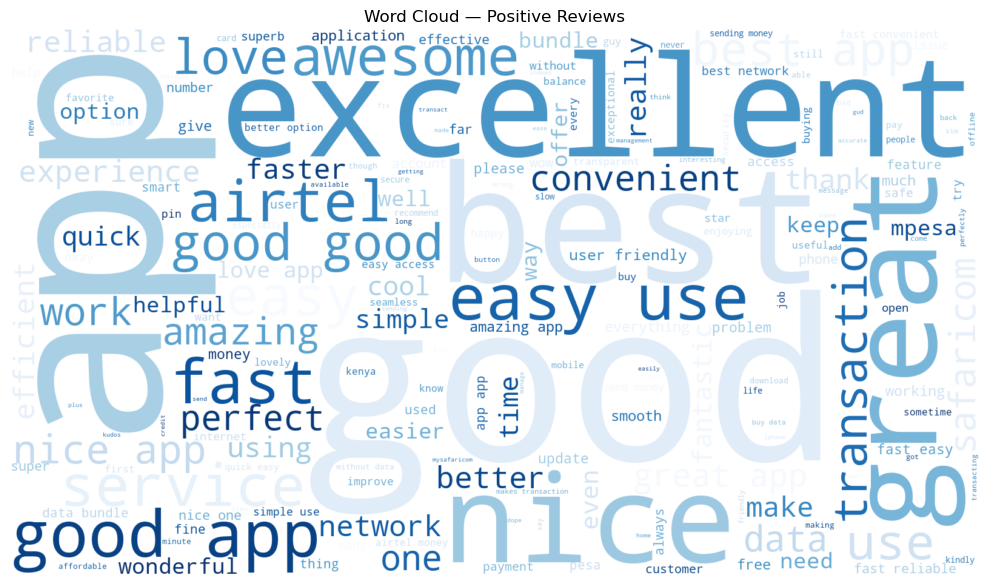

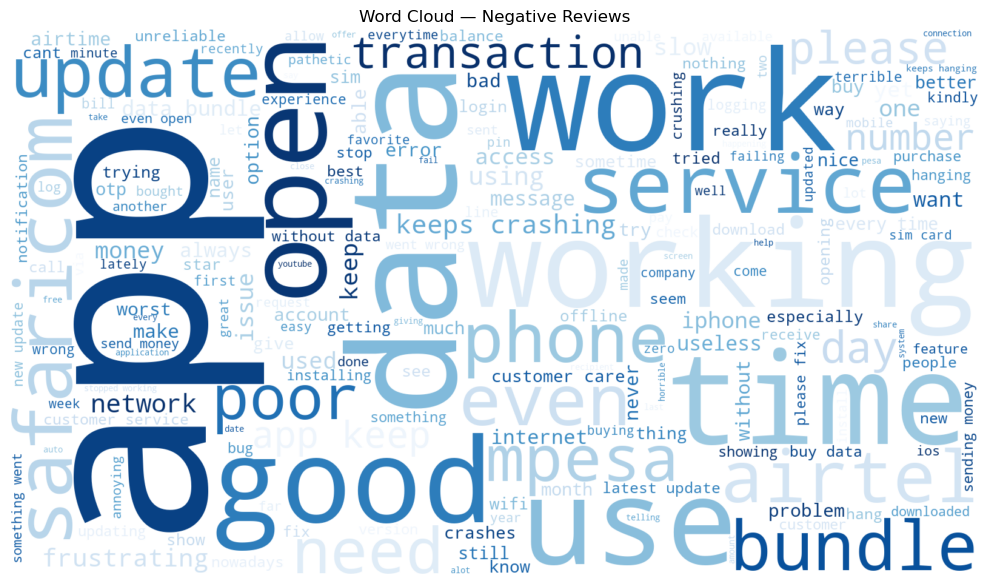

In [13]:
# ============================================================
# WORD CLOUDS BY SENTIMENT
# ============================================================
# Generates separate word clouds for Positive and Negative reviews.
# Stopwords are removed inside this block.
# ============================================================

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import Counter
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_for_wordcloud(texts):
    words = []
    for t in texts:
        t = str(t).lower()
        t = re.sub(r"[^a-z\s]", " ", t)   # keep only letters
        for tok in t.split():
            if tok not in stop_words and len(tok) > 2:
                words.append(tok)
    return " ".join(words)

for sentiment in ["positive","negative"]:
    text = clean_for_wordcloud(clean.loc[clean["sentiment"]==sentiment,"review_text"].dropna())
    if not text.strip():
        print(f"⚠️ No text for sentiment {sentiment}")
        continue
    
    wc = WordCloud(width=1600, height=900, background_color="white",
                   colormap="Blues", max_words=200).generate(text)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud — {sentiment.capitalize()} Reviews")
    plt.tight_layout()
    plt.savefig(f"Output/wordcloud_{sentiment}_blues.png", dpi=300)
    plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_6420\3151039723.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  BLUES = cm.get_cmap("Blues")
C:\Users\hp\AppData\Local\Temp\ipykernel_6420\3151039723.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sent_app = clean.groupby(["app_canonical","sentiment"]).size().unstack(fill_value=0)


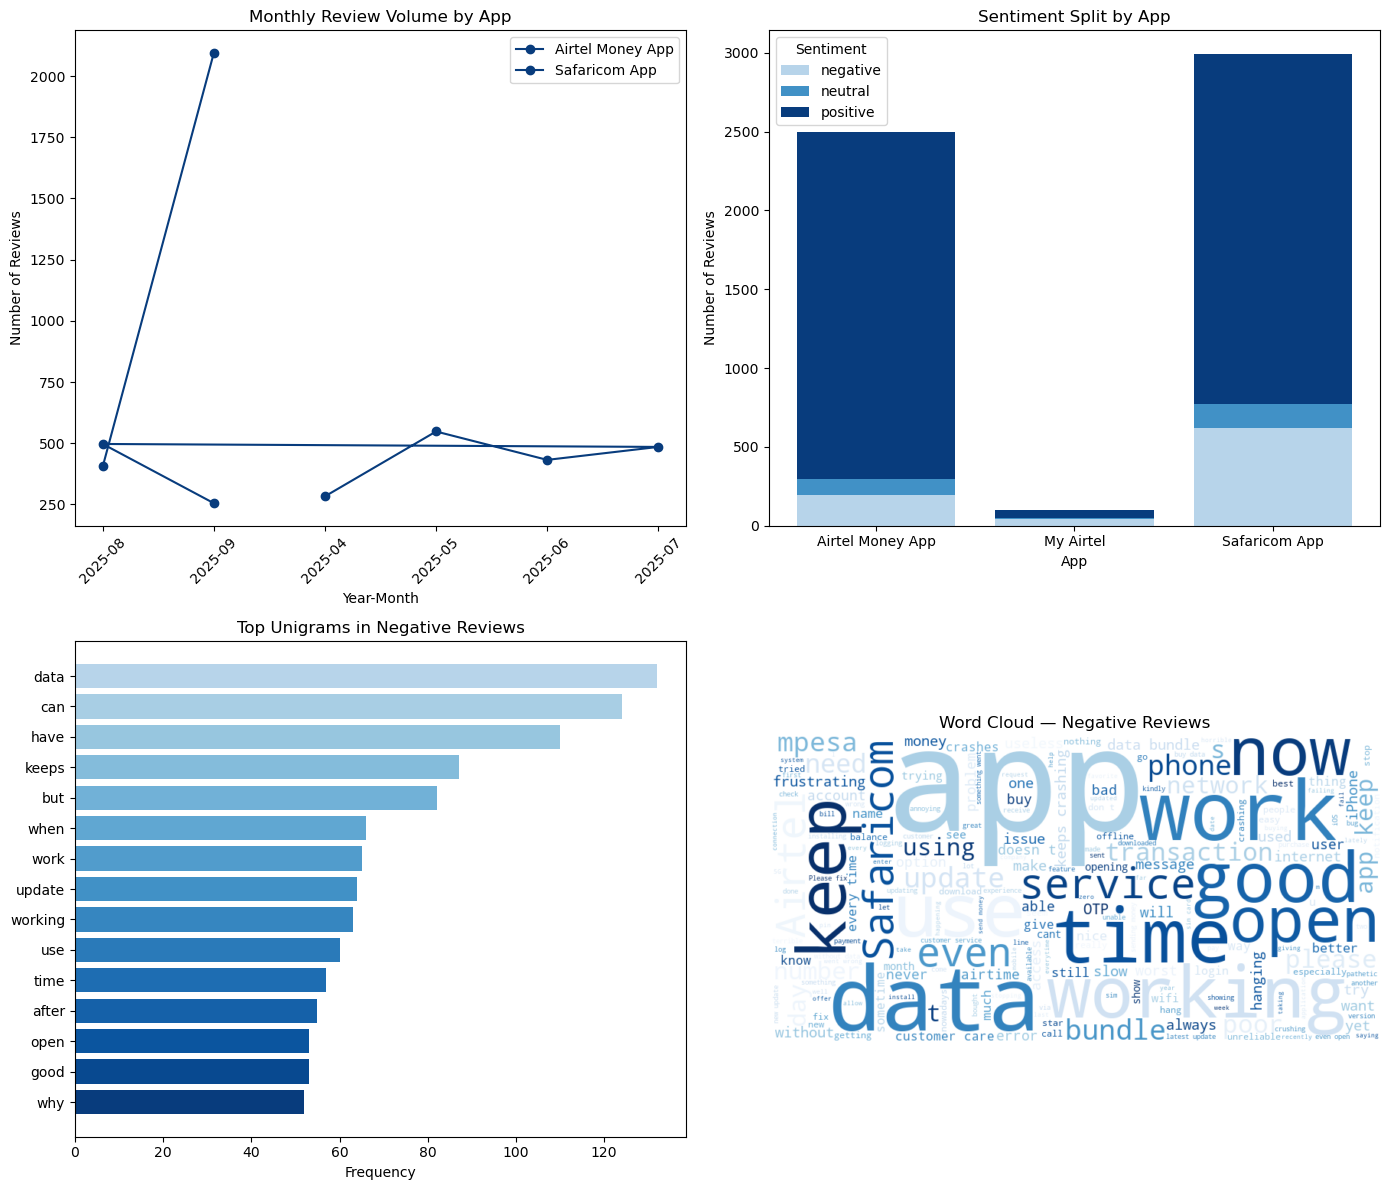

In [14]:
# ============================================================
# STEP 7 — INSIGHTS DASHBOARD
# ============================================================
# Contains 4 panels:
# 1. Monthly review volume by app
# 2. Sentiment split by app (stacked bar)
# 3. Top unigrams in negative reviews
# 4. Word clouds (negative vs positive)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re
from wordcloud import WordCloud
from matplotlib import cm
from matplotlib.colors import to_hex

# --- Helper: Blues colormap ---
BLUES = cm.get_cmap("Blues")
def blue_shades(n):
    if n <= 1:
        return [to_hex(BLUES(0.6))]
    return [to_hex(BLUES(0.3 + 0.65 * i / (n-1))) for i in range(n)]

# --- Panel 1: Monthly reviews by app ---
monthly = clean.groupby(["year_month","app_canonical"]).size().reset_index(name="n")
monthly = monthly[monthly["year_month"] != "Unknown"]

# --- Panel 2: Sentiment split by app ---
sent_app = clean.groupby(["app_canonical","sentiment"]).size().unstack(fill_value=0)
sent_app = sent_app[["negative","neutral","positive"]]  # order

# --- Panel 3: Top unigrams (negative reviews) ---
def clean_tokens(texts):
    stopwords = set("""the a an and or if to of for on at is am are was were be by with this that from as in it its it's im i'm you your we our us they them he she their there here not no yes very really just more most less least app apps airtel safaricom money mpesa m pesa my airtel google play store apple ios android phone phones""".split())
    cnt = Counter()
    for t in texts:
        t = re.sub(r"[^a-z\s]", " ", str(t).lower())
        for tok in t.split():
            if len(tok) >= 3 and tok not in stopwords:
                cnt[tok] += 1
    return cnt

neg_texts = clean.loc[clean["sentiment"]=="negative","review_text"].dropna()
top_neg = clean_tokens(neg_texts).most_common(15)
words, freqs = zip(*top_neg) if top_neg else ([],[])

# --- Panel 4: Word clouds ---
pos_texts = " ".join(clean.loc[clean["sentiment"]=="positive","review_text"].dropna().astype(str))
neg_texts_all = " ".join(neg_texts.astype(str))

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Panel 1: Monthly reviews by app
for i, (app, sdf) in enumerate(monthly.groupby("app_canonical")):
    sdf = sdf.sort_values("year_month")
    axes[0].plot(sdf["year_month"], sdf["n"], marker="o", label=app, color=blue_shades(4+i)[-1])
axes[0].set_title("Monthly Review Volume by App")
axes[0].set_xlabel("Year-Month"); axes[0].set_ylabel("Number of Reviews")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Panel 2: Sentiment split by app
bottom = np.zeros(len(sent_app))
cols = blue_shades(3)
for i, cat in enumerate(sent_app.columns):
    vals = sent_app[cat].values
    axes[1].bar(sent_app.index, vals, bottom=bottom, label=cat, color=cols[i])
    bottom += vals
axes[1].set_title("Sentiment Split by App")
axes[1].set_xlabel("App"); axes[1].set_ylabel("Number of Reviews")
axes[1].legend(title="Sentiment")

# Panel 3: Top unigrams (negative reviews)
axes[2].barh(np.arange(len(words)), freqs, color=blue_shades(len(words)))
axes[2].set_yticks(np.arange(len(words)))
axes[2].set_yticklabels(words)
axes[2].invert_yaxis()
axes[2].set_title("Top Unigrams in Negative Reviews")
axes[2].set_xlabel("Frequency")

# Panel 4: Word clouds
if pos_texts.strip() and neg_texts_all.strip():
    wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(pos_texts)
    wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(neg_texts_all)
    # show negative wordcloud
    axes[3].imshow(wc_neg, interpolation="bilinear")
    axes[3].axis("off")
    axes[3].set_title("Word Cloud — Negative Reviews")
else:
    axes[3].text(0.5,0.5,"Word Cloud Data Missing",ha="center",va="center",fontsize=14)

plt.tight_layout()
plt.savefig("Output/00_insights_dashboard_blues.png", dpi=300)
plt.show()


## Insights Dashboard Interpretation

- **Monthly Trends:**  
  - Safaricom App reviews show consistent activity across months with some fluctuations.  
  - Airtel Money App experienced a sudden spike in September 2025, suggesting a major **event or app update** triggered a surge in user feedback.  
  - Monitoring such spikes can help telcos identify release issues or service outages.  

- **Sentiment Split by App:**  
  - Both Safaricom and Airtel Money apps are dominated by **positive reviews**, but negative feedback is still notable.  
  - My Airtel has a much smaller review base, yet still reflects the same positivity bias.  
  - Safaricom App has **more total reviews**, giving it broader visibility into customer sentiment.  

- **Negative Keywords (Unigrams):**  
  - Frequent terms include **data, keeps, work, update, login, open**.  
  - These highlight recurring pain points such as **data bundle issues, app crashes, login failures, and updates breaking functionality**.  
  - Words like *“update”* and *“keeps”* suggest reliability problems after new releases.  

- **Word Cloud (Negative Reviews):**  
  - Negative reviews emphasize phrases like **“app”, “working”, “open”, “time”, “data”**.  
  - Many users explicitly complain about the app **not opening, crashing, or failing during transactions**.  
  - The prominence of transaction-related words (e.g., *transaction, airtime, money*) signals financial service reliability as a core customer pain point.  

➡️ **Business Implications:**  
- **Stability & reliability fixes** (preventing crashes and failed logins) would directly reduce negative reviews.  
- **Data & bundle management** is a recurring frustration across both apps.  
- **Spike monitoring** (e.g., Airtel Money September 2025) should become part of telco operations to quickly detect release-driven surges in complaints.  


C:\Users\hp\AppData\Local\Temp\ipykernel_6420\3444803441.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_len = clean.groupby("sentiment")["review_word_count"].mean().sort_values(ascending=False)
C:\Users\hp\AppData\Local\Temp\ipykernel_6420\3444803441.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_likes = clean.groupby("sentiment")["likes"].mean().sort_values(ascending=False)


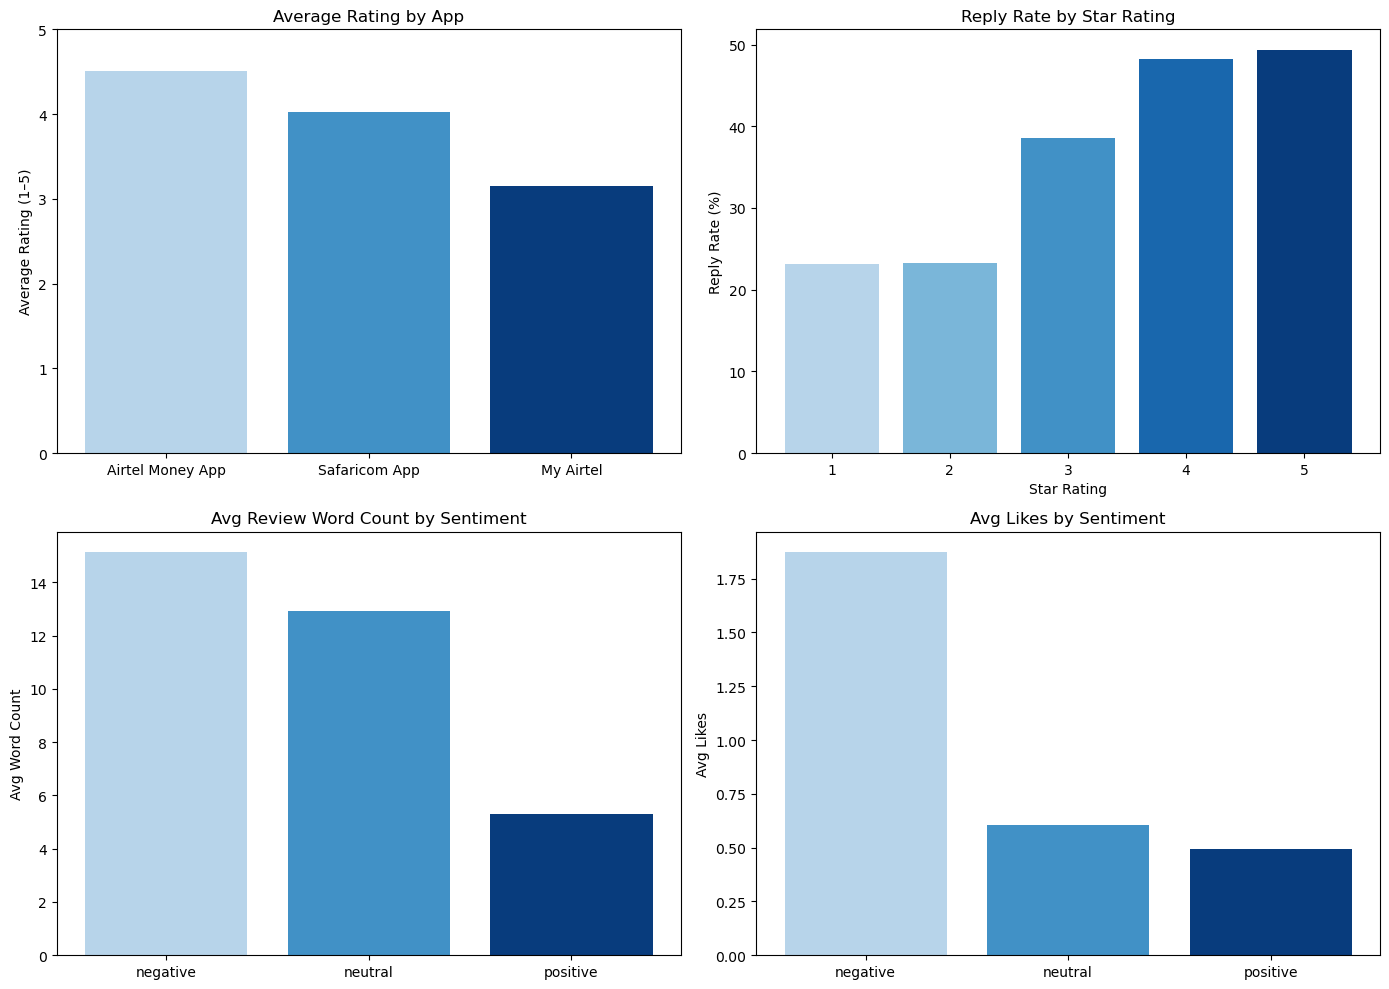

In [15]:
# ============================================================
# STEP 8b — DESCRIPTIVE STATS & ENGAGEMENT DASHBOARD
# ============================================================
# Contains 4 panels:
# 1. Average Rating by App
# 2. Reply Rate by Star Rating
# 3. Avg Review Word Count by Sentiment
# 4. Avg Likes by Sentiment
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# --- Panel 1: Average Rating by App ---
avg_ratings = clean.groupby("app_canonical")["rating"].mean().sort_values(ascending=False)
axes[0].bar(avg_ratings.index, avg_ratings.values, color=blue_shades(len(avg_ratings)))
axes[0].set_title("Average Rating by App")
axes[0].set_ylabel("Average Rating (1–5)")
axes[0].set_ylim(0,5)

# --- Panel 2: Reply Rate by Star Rating ---
reply_rate = clean.groupby("rating")["has_reply"].mean() * 100
axes[1].bar(reply_rate.index.astype(str), reply_rate.values, color=blue_shades(len(reply_rate)))
axes[1].set_title("Reply Rate by Star Rating")
axes[1].set_ylabel("Reply Rate (%)")
axes[1].set_xlabel("Star Rating")

# --- Panel 3: Avg Review Word Count by Sentiment ---
avg_len = clean.groupby("sentiment")["review_word_count"].mean().sort_values(ascending=False)
axes[2].bar(avg_len.index, avg_len.values, color=blue_shades(len(avg_len)))
axes[2].set_title("Avg Review Word Count by Sentiment")
axes[2].set_ylabel("Avg Word Count")

# --- Panel 4: Avg Likes by Sentiment ---
if "likes" in clean.columns:
    avg_likes = clean.groupby("sentiment")["likes"].mean().sort_values(ascending=False)
    axes[3].bar(avg_likes.index, avg_likes.values, color=blue_shades(len(avg_likes)))
    axes[3].set_title("Avg Likes by Sentiment")
    axes[3].set_ylabel("Avg Likes")

plt.tight_layout()
plt.savefig("Output/00_engagement_dashboard_blues.png", dpi=300)
plt.show()


## Engagement Insights Dashboard Interpretation

- **Average Rating by App:**  
  - **Airtel Money App** leads with the highest average rating (≈4.5★).  
  - **Safaricom App** follows with ≈4.0★.  
  - **My Airtel** lags behind at ≈3.1★, showing a weaker user experience and satisfaction.  

- **Reply Rate by Star Rating:**  
  - Engagement increases with higher star ratings: ~23% for 1★–2★ vs nearly 50% for 5★ reviews.  
  - This suggests telcos focus more on replying to happy users, while neglecting the most **critical 1★ complaints** — a missed opportunity for service recovery.  

- **Avg Review Word Count by Sentiment:**  
  - **Negative reviews are the longest** (≈15 words), followed by neutral reviews (≈13 words).  
  - Positive reviews are short (≈5 words), often generic praise like *“Good app”* or *“Works well”*.  
  - Longer negative reviews provide richer detail for complaint analysis and topic modeling.  

- **Avg Likes by Sentiment:**  
  - Negative reviews attract the most likes on average (≈2 likes), suggesting complaints resonate widely with other users.  
  - Positive and neutral reviews receive much less engagement, indicating **negative experiences spread faster**.  

➡️ **Business Implication:**  
- Telcos should **shift engagement efforts toward replying to long, negative reviews**, as these have the most visibility and influence.  
- Improving the My Airtel experience could significantly raise Airtel’s overall brand perception.  
